In [90]:
import numpy as np
import matplotlib.pyplot as plt
from da.l96 import lorenz96
from da.scheme import rk4
from da.loss import loss_rms
from da.visualize import plot_loss
from da.etkf import ETKF

In [91]:
# Lorenz96
# J: dim of state space
J = 40

# F: forcing
F = 8



In [92]:
# generate data
# dt: time step size
dt = 0.01

# N: number of time step, 2 years : 360*20*2
N = 360*20*2 

# initial state near the statinary point
x0 = F*np.ones(J) # the statinary point
x0[19] *= 1.001 # perturb

# use my modules
p = (F,) # parameters
scheme = rk4

result = np.zeros((N,len(x0)))
x = x0
result[0] = x[:]

for n in range(1,N):
    t = n*dt
    x = scheme(lorenz96, t, x, p, dt)
    result[n] = x[:]


x_true = result[360*20:][::5] # spin up 1 year and save per 6 hours
print(x_true.shape)

np.save(f"x_true_l96", x_true)

(1440, 40)


In [93]:
# assimilation period
Dt = 0.05

# Model function for EnKF
def M(x, Dt):
    for i in range(int(Dt/0.01)):
        x = rk4(lorenz96, 0, x, p, 0.01)
    return x

# 観測
H_diag = np.ones(J)
H_diag[::3] = 0 # partial observations

H = np.diag(H_diag)
H = H[H_diag != 0] # remove zero rows


# Model error covariance
Q = np.zeros((J, J))

# Observation error covariance
r = 1.0
R = r**2*H@H.T # operator on observation space

# random seed
seed = 0
np.random.seed(seed)

# generate observation
end_step = -1 # for development
x_true = np.load('x_true_l96.npy')[:end_step]
y = (H@x_true.T).T # observation space
y += np.random.multivariate_normal(mean=np.zeros_like(y[0]), cov=R, size=len(y)) # observation space

# initial state for EnKF
x_0 = x_true[np.random.randint(len(x_true)-1)]

P_0 = 25*np.eye(J)


In [94]:
# RUN DA
m = 25
X_0 = x_0 + np.random.multivariate_normal(np.zeros_like(x_0), P_0, m)  # (m, dim_x)
# RUN DA
etkf = ETKF(M, H, R, alpha=1.0, store_ensemble=True)
etkf.initialize(X_0)
for y_obs in y:
    etkf.forecast(Dt)
    etkf.update(y_obs)

x_assim = etkf.x

In [95]:
# RUN DA
alpha = 1.2
m = 25
X_0 = x_0 + np.random.multivariate_normal(np.zeros_like(x_0), P_0, m)  # (m, dim_x)
# RUN DA
etkf_alpha = ETKF(M, H, R, alpha=alpha, store_ensemble=True)
etkf_alpha.initialize(X_0)
for y_obs in y:
    etkf_alpha.forecast(Dt)
    etkf_alpha.update(y_obs)

x_assim_alpha = etkf_alpha.x

time averaged RMSE for ETKF: 4.0541
time averaged RMSE for ETKF-inf:0.3409


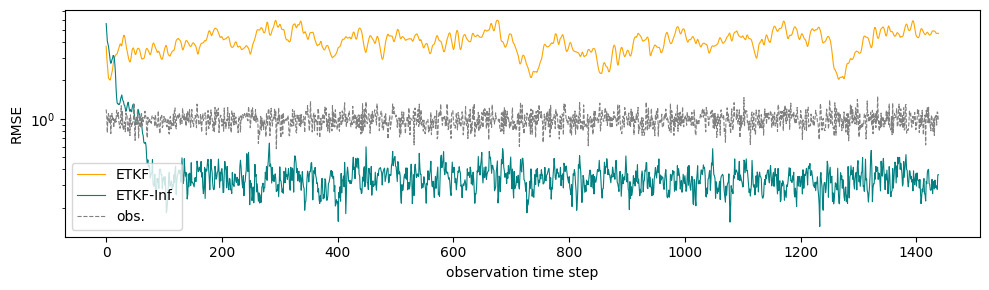

In [96]:
# Plot
fig, ax = plt.subplots(figsize=(10, 3))
plot_loss(x_true, x_assim, loss_rms, ax=ax, label='ETKF', lw=0.8, color="orange")
plot_loss(x_true, x_assim_alpha, loss_rms, ax=ax, label='ETKF-Inf.', lw=0.8, color="teal")
plot_loss((H@x_true.T).T, y, loss_rms, ax=ax, label='obs.', lw=0.8, color="gray", ls="--")
ax.set_xlabel('observation time step')
ax.set_ylabel('RMSE')
ax.legend()
ax.set_yscale('log')
fig.tight_layout()
# fig.savefig("etkf_inflation_result.pdf")

# time averaged RMSE
rmse_avg = np.linalg.norm(x_true-x_assim, axis=1)[-1000:].mean() / np.sqrt(J)  # RMSE
rmse_avg_alpha = np.linalg.norm(x_true-x_assim_alpha, axis=1)[-1000:].mean() / np.sqrt(J)  # RMSE
print(f"time averaged RMSE for ETKF: {rmse_avg:.4f}", )
print(f"time averaged RMSE for ETKF-inf:{rmse_avg_alpha:.4f}")

Text(0.5, 0.98, 'spatio-temporal plot: from t=0 to t=500')

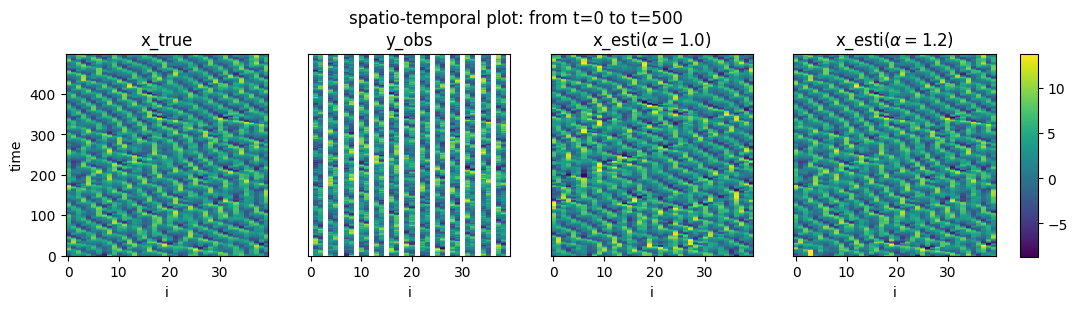

In [97]:
t_start = 0
t_end = 500
x1 = x_true[t_start:t_end]
y_extend = (H.T@y[t_start:t_end].T).T # embed y into state space: (T, Ny) -> (T, Nx)
y_mask = np.ma.masked_where(y_extend==0.0, y_extend)
x2 = y_mask
x3 = x_assim[t_start:t_end]
x4 = x_assim_alpha[t_start:t_end]

vmax = np.max(x1)
vmin = np.min(x1)
fig, ax = plt.subplots(1, 4, figsize=(3*4, 3))
im = ax[0].imshow(x1, aspect=J/(t_end-t_start), vmax=vmax, vmin=vmin, origin="lower", interpolation="none")
ax[0].set_ylabel("time")
ax[0].set_xlabel("i")
ax[0].set_title("x_true")

ax[1].imshow(x2, aspect=J/(t_end-t_start), vmax=vmax, vmin=vmin, origin="lower", interpolation="none")
ax[1].set_xlabel("i")
ax[1].set_title("y_obs")
ax[1].set_yticks([])

ax[2].imshow(x3, aspect=J/(t_end-t_start), vmax=vmax, vmin=vmin, origin="lower", interpolation="none")
ax[2].set_xlabel("i")
ax[2].set_title("x_esti($\\alpha=1.0$)")
ax[2].set_yticks([])

ax[3].imshow(x4, aspect=J/(t_end-t_start), vmax=vmax, vmin=vmin, origin="lower", interpolation="none")
ax[3].set_xlabel("i")
ax[3].set_title("x_esti($\\alpha=1.2$)")
ax[3].set_yticks([])

cax = fig.add_axes([0.92, 0.155, 0.015, 0.675])

fig.colorbar(im, cax=cax)
fig.suptitle(f"spatio-temporal plot: from t={t_start} to t={t_end}")

## Looking at the covariance matrix

In [98]:
# def compute_cov(Xf):
#     return np.array([np.cov(Xft.T) for Xft in Xf])

In [99]:
# Xa= np.array(etkf.XXa
# C_a = compute_cov(Xa
# Xaalpha = np.array(etkf_alpha.XXa
# C_a_alpha = compute_cov(Xaalpha)

# Xf = np.array(etkf.Xf)
# C_f = compute_cov(Xf)
# Xf_alpha = np.array(etkf_alpha.Xf)
# C_f_alpha = compute_cov(Xf_alpha)

# fig, ax = plt.subplots(figsize=(10, 2))
# ax.plot(np.sqrt(np.trace(np.array(C_f), axis1=1, axis2=2)/J), label="f ETKF")
# ax.plot(np.sqrt(np.trace(np.array(C_f_alpha), axis1=1, axis2=2)/J), label="f ETKF + Inf.")
# ax.plot(np.sqrt(np.trace(np.array(C_a), axis1=1, axis2=2)/J), label="a ETKF")
# ax.plot(np.sqrt(np.trace(np.array(C_a_alpha), axis1=1, axis2=2)/J), label="a ETKF + Inf.")
# ax.set_ylim([0, 1])
# ax.set_title("$tr(P^f)$")
# plt.legend()

In [100]:
# import scipy as sp

# evals = np.array([sp.linalg.eigvals(C_ft) for C_ft in C_f])
# logevals = np.log(evals)
# plt.plot(logevals[:, :23], lw=0.4)
# plt.legend()
# plt.ylim(-10, 1)
# plt.show()

# range_logevals = logevals[:, 0] - logevals[:, 23]
# plt.plot(range_logevals)
# # plt.ylim(0, 1)

In [101]:
# evals_alpha = np.array([sp.linalg.eigvals(C_ft) for C_ft in C_f_alpha])
# logevals_alpha = np.log(evals_alpha)
# plt.plot(logevals_alpha[:, :23], lw=0.4)
# plt.legend()
# plt.ylim(-10, 1)

# plt.show()


# range_logevals_alpha = logevals_alpha[:, 0] - logevals_alpha[:, 23]
# plt.plot(range_logevals_alpha)
# plt.ylim(0)

In [102]:
# logevals_alpha[100, 24]